### Lifetime value example 


Suppose we have a subscription business that has monthly churn, and we'd like to know an estimate of LTV (lifetime value) and build confidence intervals for it. 


Subscription businesses have a very predictable churn profile (it looks piecewise) but the rates are unknown. 





We'll use a piecewise-constant hazard model with known breakpoints, $\tau$.
$$ 
h(t) = \begin{cases}
                        \lambda_0  & \text{if $t \le \tau_0$} \\
                        \lambda_1 & \text{if $\tau_0 < t \le \tau_1$} \\
                        \lambda_2 & \text{if $\tau_1 < t \le \tau_2$} \\
                        ...
                      \end{cases}
$$



In [31]:
%matplotlib inline
from autograd import numpy as np
from autograd import elementwise_grad, value_and_grad, hessian
from scipy.optimize import minimize

df = pd.read_csv("../churn_data.csv")
T = df['T'].values
E = df['E'].values

In [2]:
breakpoints = np.array([28,  33,  58,  63,  88,  93,  117, 122, 148, 153])

def cumulative_hazard(params, times):
    # this is NumPy black magic to get piecewise hazards, let's chat after. 
    times = np.atleast_1d(times)
    n = times.shape[0]
    times = times.reshape((n, 1))
    M = np.minimum(np.tile(breakpoints, (n, 1)), times)
    M = np.hstack([M[:, tuple([0])], np.diff(M, axis=1)])
    return np.dot(M, params)

hazard = elementwise_grad(cumulative_hazard, argnum=1)

def survival_function(params, t):
    return np.exp(-cumulative_hazard(params, t))

def log_hazard(params, t):
    return np.log(np.clip(hazard(params, t), 1e-25, np.inf))

def log_likelihood(params, t, e):
    return np.sum(e * log_hazard(params, t)) - np.sum(cumulative_hazard(params, t))

def negative_log_likelihood(params, t, e):
    return -log_likelihood(params, t, e)

from autograd import value_and_grad

results = minimize(
        value_and_grad(negative_log_likelihood), 
        x0 = np.ones(len(breakpoints)),
        method=None, 
        args=(T, E),
        jac=True,
        bounds=[(0.0001, None)] * len(breakpoints)
)

print(results)
estimates_ = results.x
H = hessian(negative_log_likelihood)(estimates_, T, E)
variance_matrix_ = np.linalg.inv(H)

      fun: 6820.877953596707
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.57181706, -0.16753806, -0.06621519, -0.19042741, -0.09172935,
        0.04749549,  0.1030577 , -0.21740178, -0.08800897, -0.21890358])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 67
      nit: 46
   status: 0
  success: True
        x: array([0.00103406, 0.03326294, 0.00104654, 0.01516408, 0.0005534 ,
       0.01317414, 0.00099483, 0.01216659, 0.0012531 , 0.00689811])


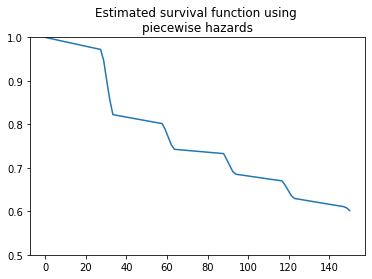

In [3]:
t = np.linspace(.001, 150, 100)
plt.plot(t, survival_function(estimates_, t))
plt.ylim(0.5, 1)
plt.title("""Estimated survival function using \npiecewise hazards""");

On day 30, we charge users \\$10, and on every 30 days after that, we charge \\$20. What's the LTV, and CIs, at the end of day 120?

In [4]:
def LTV_120(params):
    # think about how complicated the gradient of this function is. Now imagine an even more
    # complicated function.
    ltv = 0
    ltv += 10 * survival_function(params, 30)
    for t in [60, 90, 120]:
        ltv += 20 * survival_function(params, t)
    return ltv

In [5]:
ltv_ = LTV_120(estimates_)
print("LTV estimate: ", ltv_)

LTV estimate:  [51.82507427]


In [6]:
from autograd import grad
var_ltv_= grad(LTV_120)(estimates_) @ variance_matrix_ @ grad(LTV_120)(estimates_)
print("Variance LTV estimate:", var_ltv_)

Variance LTV estimate: 1.605494065103963


In [7]:
std_ltv = np.sqrt(var_ltv_)
print("Estimated LTV at day 120: ($%.2f, $%.2f)" % (ltv_ - 1.96 * std_ltv, ltv_ + 1.96 * std_ltv))

Estimated LTV at day 120: ($49.34, $54.31)


From here, we can compute p-values, scenario analysis, sensitvity analysis, etc. 

Let's continue this analytical train to Part 8. 

### Bonus, if time permits and Cameron is talking too fast. 

In the above model, we are not suggesting to the model much apriori information about this "predictable" process. For example, suppose we want a model that gives "inbetween" period rates to be close to each other, and likewise for the "jump" rates. 

In [28]:

def negative_log_likelihood(params, t, e):
    return -log_likelihood(params, t, e) + 1e12 * (np.var(params[::2]) + np.var(params[1::2]))

from autograd import value_and_grad

results = minimize(
        value_and_grad(negative_log_likelihood), 
        x0 = np.ones(len(breakpoints)),
        method=None, 
        args=(T, E),
        jac=True,
        bounds=[(0.0001, None)] * len(breakpoints)
)

print(results)
estimates_ = results.x

      fun: 6839.426915809169
 hess_inv: <10x10 LbfgsInvHessProduct with dtype=float64>
      jac: array([-46.78891729,  23.72599913, -12.19979075,  40.04503677,
        63.39941388,  -7.47615848,   8.16437802, -27.76700067,
       -11.54179562, -28.46781927])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 45
      nit: 32
   status: 0
  success: True
        x: array([0.000976  , 0.01823817, 0.000976  , 0.01823816, 0.00097599,
       0.01823816, 0.000976  , 0.01823816, 0.00097601, 0.01823816])


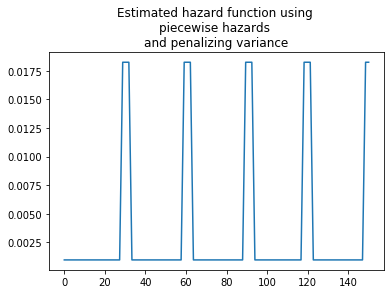

In [30]:
t = np.linspace(.001, 150, 100)
plt.plot(t, hazard(estimates_, t))
plt.title("""Estimated hazard function using \npiecewise hazards \nand penalizing variance""");

### Why do this?

1) From a Bayesian perspective, this is a way to add prior information into a model. Note that if we have _lots_ of observations, the prior becomes less relevant (just like a traditional Bayesian model). That's good. *We are again using the likelihood to "add" information to our system.*

2) When we have low data sizes, we can "borrow" information between periods. That is, deaths in the earlier "inbetween" periods can inform the rate in the later "inbetween" periods - thus we can do better inference. 
